In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('uber.csv')
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,49:00.0,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,09:00.0,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,42:00.0,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,56:25.0,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695416,1


In [2]:
# Display basic info
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing target values (fare)
df.dropna(subset=['fare_amount'], inplace=True)

# Convert pickup_datetime to datetime and extract features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Calculate distance using pickup and dropoff latitude/longitude (Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)*2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)*2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

# Drop any rows with invalid distance
df = df[df['distance_km'] > 0]

# Remove unwanted columns (like datetime)
df.drop(columns=['pickup_datetime'], inplace=True)

# Check the dataframe
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
   Unnamed: 0      key  fare_amount  pickup_longitude  pickup_l

C:\Users\akshata landge\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\akshata landge\AppData\Local\Temp\ipykernel_19968\3388952823.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['pickup_datetime'], inplace=True)


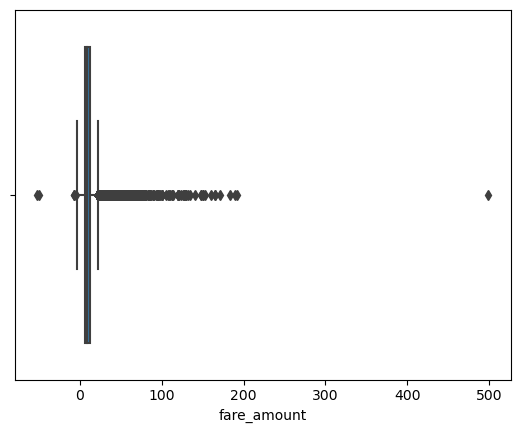

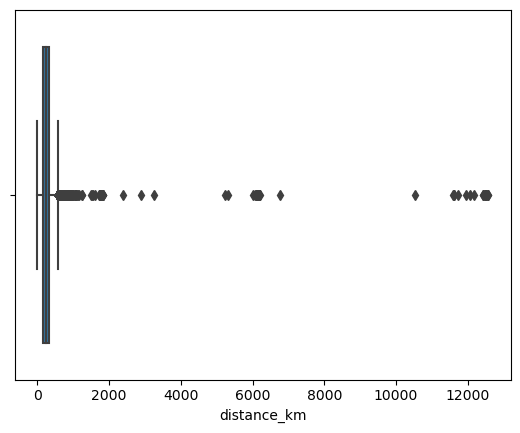

In [3]:
# Boxplot to identify outliers in fare_amount and distance
sns.boxplot(x=df['fare_amount'])
plt.show()

sns.boxplot(x=df['distance_km'])
plt.show()

# Remove extreme outliers (optional, based on business rule)
df = df[df['fare_amount'] < df['fare_amount'].quantile(0.99)]
df = df[df['distance_km'] < df['distance_km'].quantile(0.99)]

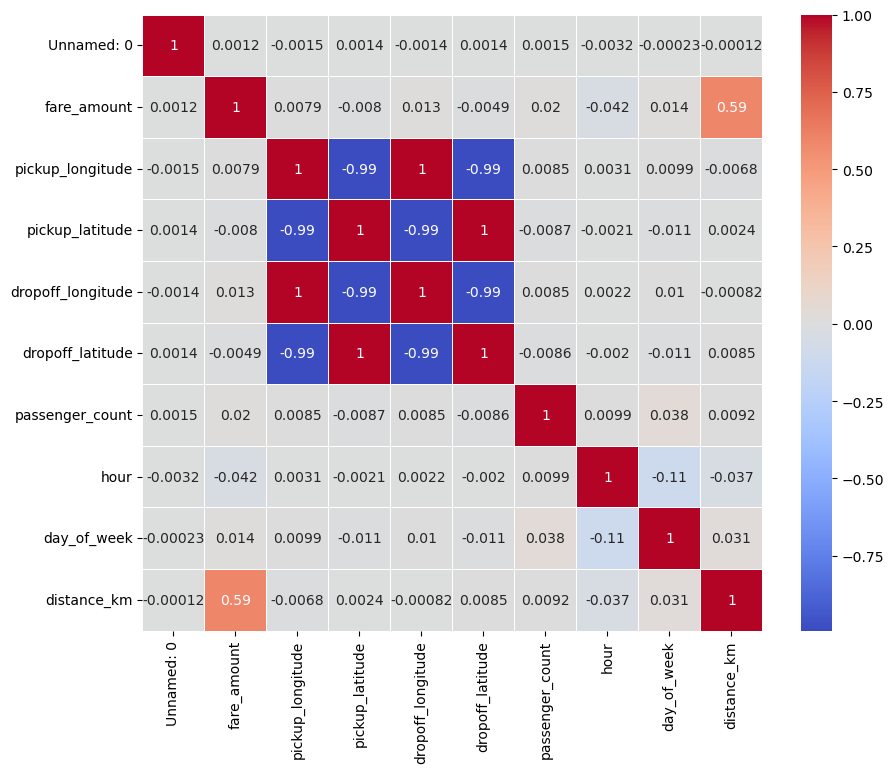

In [4]:


# Select only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Handle missing values (e.g., drop or fill)
numeric_df = numeric_df.dropna()  # You can also use .fillna() to fill missing values

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Display the plot
plt.show()


In [5]:
# Features and target variable
X = df[['distance_km', 'hour', 'day_of_week']]  # Use relevant features
y = df['fare_amount']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

In [6]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}')

# Evaluate Linear Regression
evaluate_model(y_test, y_pred_lin, 'Linear Regression')

# Evaluate Ridge Regression
evaluate_model(y_test, y_pred_ridge, 'Ridge Regression')

# Evaluate Lasso Regression
evaluate_model(y_test, y_pred_lasso, 'Lasso Regression')

Linear Regression - R2: 0.3652, RMSE: 5.6926
Ridge Regression - R2: 0.3652, RMSE: 5.6926
Lasso Regression - R2: 0.3647, RMSE: 5.6952
